This file is the implemented version of branch and bound that's being used to solve specific type of data(job assignment with constraint) the example data is in DataFile5w.py

In [17]:
import random
import csv
import time

def generate_job_pref(preference_size):
    job_preferences = []
    shuffled_jobid = [jobid for jobid in range(1, preference_size+1)]
    random.shuffle(shuffled_jobid)
    for index, jobid in enumerate(shuffled_jobid):
        job_preference = [jobid, 30-index, random.randint(1, 6)]
        job_preferences.append(job_preference)
    return job_preferences
def generate_worker_data(worker_id, preference_size):
    return [
        worker_id, # Seniority no 
        random.randint(1, 6),  # Rank
        random.randint(1, 3),  # Job
        generate_job_pref(preference_size),
        random.randint(0, 1)  # Random assignment
    ]

def generate_job_data(job_id):
    return [
        job_id,
        f"Job{job_id}",
        f"Pos{job_id}",
        [random.randint(5, 10) for _ in range(6)]
    ]

def randomize_ja_data(worker_size, job_size, pref_size):
    # Generate worker data
    worker_datas = [generate_worker_data(i, pref_size) for i in range(worker_size)]
    # Generate job data
    job_datas = [generate_job_data(i) for i in range(1, job_size+1)] # the size of jobs must be more >= preferences size to prevent index out of range
    # job_datas = [generate_job_data(i) for i in range(1, 200)] # the size of jobs must be more >= preferences size to prevent index out of range
    return worker_datas, job_datas

def to_csv(data):
    with open('file.csv', 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['seniority number', 'rank', 'job', 'preferences'])
        for worker in data:
            writer.writerow([worker])


    

In [18]:
def generate_dict(key, values):
    result_dict = []

    for value in values:
        key_pair = zip(key, value)
        result_dict.append(dict(key_pair))

    return result_dict

In [19]:
import copy
class Worker:
    def __init__(self, prioritynumber, currentrank, currentjobid, scores, reloctype) -> None:
        self.prioritynumber = prioritynumber
        self.currentrank = currentrank
        self.currentjob = currentjobid
        self.scores = scores # appraisals score for each job
        self.reloctype = reloctype # if relocate => 0, if promotion => 1 

class Job: 
    def __init__(self, jobid, jobname, positionname, capacitylist) -> None:
        self.jobid = jobid
        self.name = jobname
        self.position = positionname
        self.capacitylist = capacitylist
    
    def getcap(self, rank):
        return self.capacitylist[rank-1]


def bnb_wc(worker_list, job_list):
    upper_bound = -1
    assignment_result = []

    iteration = 0
    combination = 0

    unpruned_nodes = [(0, [], worker_list, job_list)]
    job_remains = []

    while unpruned_nodes:

        cost, assignment, workers, jobs = unpruned_nodes.pop()
        iteration += 1
        if len(workers) == 0: # all worker are assigned then we can check the score/cost to set result and bound
            combination += 1
            if cost > upper_bound:
                assignment_result = assignment
                upper_bound = cost
                job_remains = jobs
        else:
            for worker_job in workers[0].scores:
                jobs_copy = copy.deepcopy(jobs)
                preferred_job = jobs_copy[worker_job[0] - 1]
                current_worker = workers[0]
                if preferred_job.getcap(worker_job[-1]) > 0: # check capacity constraint
                    new_assignment = assignment + [worker_job]
                    new_cost = cost + worker_job[1]
                    jobs_copy[worker_job[0] - 1].capacitylist[worker_job[-1]-1] -= 1
                elif jobs_copy[current_worker.currentjob - 1].getcap(current_worker.currentrank) > 0: # check if worker can fit their old job or not 
                    # print('Can fit old job')
                    new_assignment = assignment + [[current_worker.currentjob, current_worker.scores[-1][1] - 1, current_worker.currentrank]]
                    new_cost = cost + current_worker.scores[-1][1] - 1
                    jobs_copy[current_worker.currentjob - 1].capacitylist[current_worker.currentrank - 1] -= 1
                else: # if worker can't fit neither preferred job or their old job then do not add new node to explore
                    # print('Cannot fit any job')
                    continue # no need to explore more deep
                new_worker_list = workers[1:]
                # print(new_assignment)
                unpruned_nodes.append((new_cost, new_assignment, new_worker_list, jobs_copy))
    return assignment_result, upper_bound, combination, iteration, job_remains


# Worker Datas And Job DatasÍ
worker_datas = [
        # PriorityNo, Rank, Job
        [1, 5, 1, [ # worker 1
            # JobId, Score, JobRank
            [2, 30, 5],
            [3, 29, 5],
            [4, 28, 5]
        ], 0], # Relocation Type 1 -> Promotion, 0 -> Relocation
        [2, 5, 1, [ # worker 2
            # JobId, Score, JobRank
            [2, 30, 6],
            [3, 29, 6],
            [4, 28, 6]
        ], 1],
        [3, 5, 1, [ # worker 3
            # JobId, Score, JobRank
            [2, 30, 6],
            [3, 29, 6],
            [4, 28, 6]
        ], 0],
        [4, 4, 3, [ # worker 4
            # JobId, Score, JobRank
            [1, 30, 4],
            [2, 29, 4],
            [4, 28, 4],
            [5, 27, 4]
        ], 0],
        [5, 4, 2, [ # worker 5
            # JobId, Score, JobRank
            [1, 30, 4],
            [3, 29, 4],
            [4, 28, 4],
            [5, 27, 4]
        ], 1]
    ]

job_datas = [
    [1, "Job1", "Pos1", [1, 1, 1, 1, 1, 1]],
    [2, "Job2", "Pos2", [0, 1, 1, 0, 1, 1]],
    [3, "Job3", "Pos3", [1, 0, 1, 1, 0, 1]],
    [4, "Job4", "Pos4", [1, 1, 0, 1, 1, 0]],
    [5, "Job5", "Pos5", [0, 1, 0, 1, 1, 0]],
    [6, "Job6", "Pos6", [1, 1, 1, 0, 0, 1]],
    [7, "Job7", "Pos7", [0, 0, 1, 1, 1, 0]],
    [8, "Job8", "Pos8", [1, 1, 0, 0, 1, 1]],
    [9, "Job9", "Pos9", [1, 1, 1, 1, 0, 0]],
    [10, "Job10", "Pos10", [0, 1, 1, 0, 0, 1]],
    [11, "Job11", "Pos11", [1, 0, 1, 0, 1, 1]]
]

execution_times = []

# wdatas = worker_datas
# jdatas = job_datas
size = 8



In [27]:
def testbnb(wdatas, jdatas):
    worker_lists = []
    job_lists = []
    for worker in wdatas:
        new_worker = Worker(worker[0], worker[1], worker[2], worker[3], worker[4])
        worker_lists.append(new_worker)

    for job in jdatas:
        new_job = Job(job[0], job[1], job[2], job[3])
        job_lists.append(new_job)

    # Test Clearing slot
    copy_of_job_lists = job_lists
    # for job in copy_of_job_lists:
        # job.capacitylist = [0]*6 # Fill 0 in capacitylist
        # job.capacitylist = [5]*6 # Fill 0 in capacitylist
        # print(f"{job.name} capacity {job.capacitylist}")

    for worker in worker_lists:
        worker_currentjob = copy_of_job_lists[worker.currentjob-1] # get worker current job
        worker_currentjob.capacitylist[worker.currentrank-1] += 1 # +1 for worker current job

    # print("\nClearing slot\n")

    # for job in copy_of_job_lists:
    #     print(f"{job.name} capacity {job.capacitylist}")

    result, score, combination, iteration, remaining_jobs = bnb_wc(worker_lists, copy_of_job_lists)
    return result, score, combination, iteration, remaining_jobs

In [21]:
wdatas, jdatas = randomize_ja_data(6, 6, 5)

for w in wdatas:
    print(w)
for j in jdatas:
    print(j)

[0, 3, 3, [[3, 30, 4], [2, 29, 1], [5, 28, 5], [1, 27, 5], [4, 26, 3]], 1]
[1, 1, 2, [[5, 30, 5], [4, 29, 4], [2, 28, 3], [1, 27, 4], [3, 26, 1]], 0]
[2, 3, 3, [[3, 30, 4], [1, 29, 4], [2, 28, 3], [4, 27, 4], [5, 26, 6]], 1]
[3, 2, 2, [[4, 30, 1], [1, 29, 5], [2, 28, 5], [3, 27, 1], [5, 26, 4]], 1]
[4, 2, 1, [[1, 30, 6], [4, 29, 4], [5, 28, 1], [2, 27, 1], [3, 26, 6]], 0]
[5, 2, 1, [[3, 30, 3], [4, 29, 2], [5, 28, 2], [1, 27, 1], [2, 26, 2]], 0]
[1, 'Job1', 'Pos1', [8, 8, 7, 5, 8, 8]]
[2, 'Job2', 'Pos2', [10, 6, 6, 10, 8, 8]]
[3, 'Job3', 'Pos3', [8, 5, 9, 6, 10, 8]]
[4, 'Job4', 'Pos4', [10, 8, 5, 5, 9, 5]]
[5, 'Job5', 'Pos5', [5, 9, 9, 8, 10, 6]]
[6, 'Job6', 'Pos6', [8, 9, 6, 10, 7, 8]]


In [30]:
size = 12
for s in range(5, size):
    print(f"{s}x{s}")
    wdatas, jdatas = randomize_ja_data(s, s, 5)
    start = time.perf_counter()
    result, score, combination, iteration, remaining_jobs = testbnb(wdatas, jdatas)
    end = time.perf_counter()
    exec_time = end-start
    print(f"iteration {iteration} combination {combination}. result {result} score {score}.")
    print(f"Execution Time {exec_time}.\n")
    execution_times.append(exec_time)

5x5
iteration 3906 combination 3125. result [[1, 30, 4], [5, 30, 5], [2, 30, 5], [3, 30, 4], [4, 30, 2]] score 150.
Execution Time 0.12120059999961086.

6x6
iteration 19531 combination 15625. result [[4, 30, 1], [1, 30, 1], [4, 30, 6], [1, 30, 6], [4, 30, 5], [2, 30, 5]] score 180.
Execution Time 0.6638999999995576.

7x7
iteration 97656 combination 78125. result [[5, 30, 2], [1, 30, 2], [4, 30, 2], [1, 30, 4], [2, 30, 4], [5, 30, 2], [5, 30, 5]] score 210.
Execution Time 4.0915715000001.

8x8
iteration 488281 combination 390625. result [[5, 30, 5], [2, 30, 3], [2, 30, 3], [3, 30, 2], [3, 30, 6], [5, 30, 1], [3, 30, 2], [2, 30, 6]] score 240.
Execution Time 22.465406499999517.

9x9
iteration 2441406 combination 1953125. result [[3, 30, 4], [4, 30, 4], [2, 30, 6], [2, 30, 5], [5, 30, 1], [4, 30, 1], [1, 30, 5], [1, 30, 2], [1, 30, 5]] score 270.
Execution Time 125.8641405999997.

10x10
iteration 12207031 combination 9765625. result [[5, 30, 3], [3, 30, 3], [4, 30, 4], [2, 30, 5], [2, 30,

In [2]:
# print(execution_times)
execution_times = [0.12120059999961086, 0.6638999999995576, 4.0915715000001, 22.465406499999517, 125.8641405999997, 691.7201392999996, 3868.1306010999997]

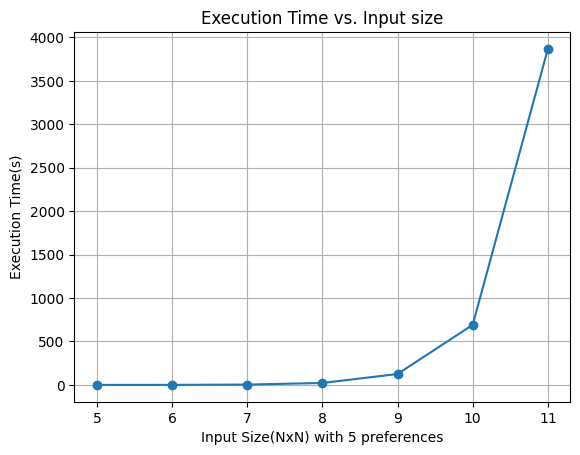

In [4]:
import matplotlib.pyplot as plt

# Create x values (indices)
x_values = [i for i in range(5, 12)]

plt.plot(x_values, execution_times, marker='o')
plt.xlabel('Input Size(NxN) with 5 preferences')
plt.ylabel('Execution Time(s)')
plt.title('Execution Time vs. Input size')
plt.grid(True)
plt.show()

In [25]:
from DataFile5w import worker_datas as wd, job_datas as jd
for w in wd:
    print(w)
for j in jd:
    print(j)
result, score, combination, iteration, remaining_jobs = testbnb(wd, jd)
print(f"iteration {iteration} combination {combination}. result {result} score {score}")



[0, 5, 1, [[13, 30, 5], [2, 29, 5], [3, 28, 5], [4, 27, 5], [5, 26, 5], [6, 25, 5], [7, 24, 5], [8, 23, 5], [9, 22, 5], [10, 21, 5]], 0]
[1, 5, 1, [[2, 30, 5], [3, 29, 5], [4, 28, 5], [1, 27, 5], [5, 26, 5], [6, 25, 5], [7, 24, 5], [8, 23, 5], [9, 22, 5], [10, 21, 5]], 0]
[2, 5, 1, [[3, 30, 6], [4, 29, 6], [5, 28, 6], [2, 27, 6], [6, 26, 6], [7, 25, 6], [8, 24, 6], [9, 23, 6], [10, 22, 6], [1, 21, 6]], 1]
[3, 4, 3, [[4, 30, 4], [5, 29, 4], [6, 28, 4], [3, 27, 4], [7, 26, 4], [8, 25, 4], [9, 24, 4], [10, 23, 4], [1, 22, 4], [2, 21, 4]], 0]
[4, 4, 2, [[5, 30, 4], [6, 29, 4], [7, 28, 4], [4, 27, 4], [8, 26, 4], [9, 25, 4], [10, 24, 4], [1, 23, 4], [2, 22, 4], [3, 21, 4]], 1]
[1, 'Job1', 'Pos1', [6, 5, 4, 1, 2, 1]]
[2, 'Job2', 'Pos2', [1, 2, 3, 69, 5, 6]]
[3, 'Job3', 'Pos3', [1, 0, 1, 1, 0, 1]]
[4, 'Job4', 'Pos4', [1, 1, 0, 1, 0, 0]]
[5, 'Job5', 'Pos5', [0, 1, 0, 1, 1, 0]]
[6, 'Job6', 'Pos6', [1, 1, 1, 0, 0, 1]]
[7, 'Job7', 'Pos7', [0, 0, 1, 1, 1, 0]]
[8, 'Job8', 'Pos8', [1, 1, 0, 0, 1, 1]